_version log: comparing the change in wavelengths as the ROI changes, using animations_

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation
from PIL import Image

pixel_pitch = 9.9 #um

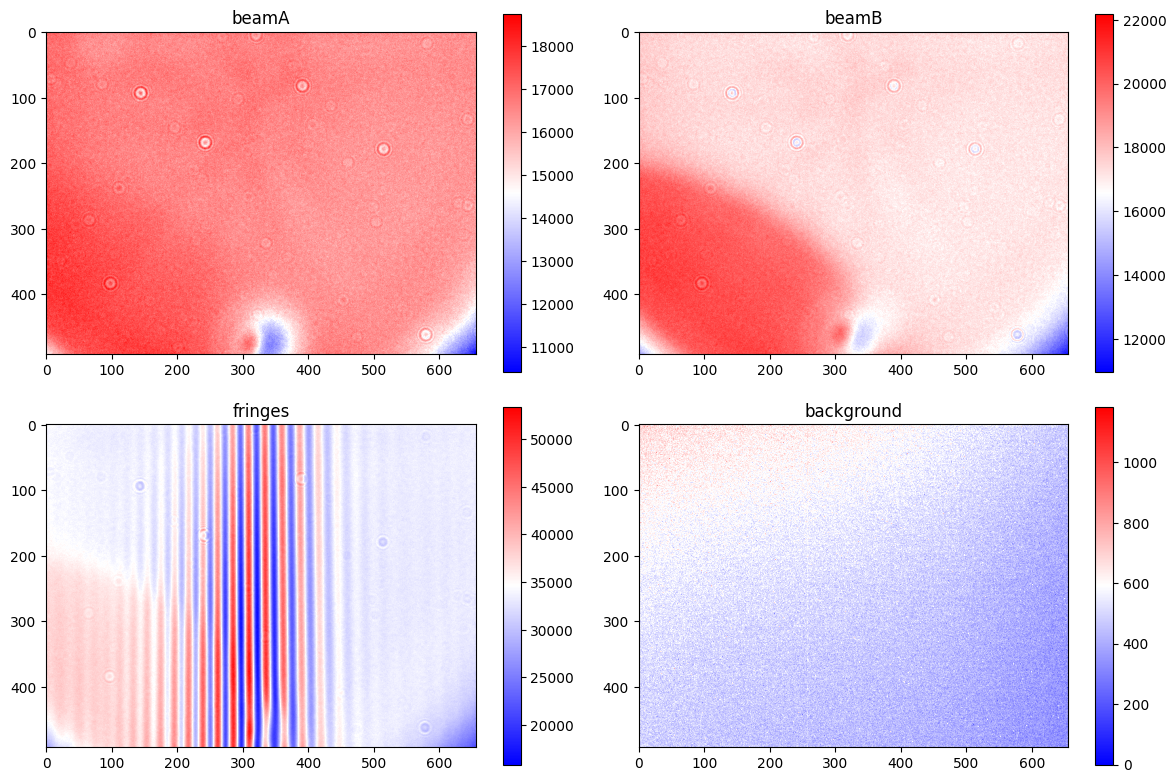

In [43]:
def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

fringes, beamA, beamB, background = import_standard_tif("ir", "5")

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background")

plt.tight_layout()
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23084\2091882736.py:44: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +2]


<Figure size 1400x600 with 0 Axes>

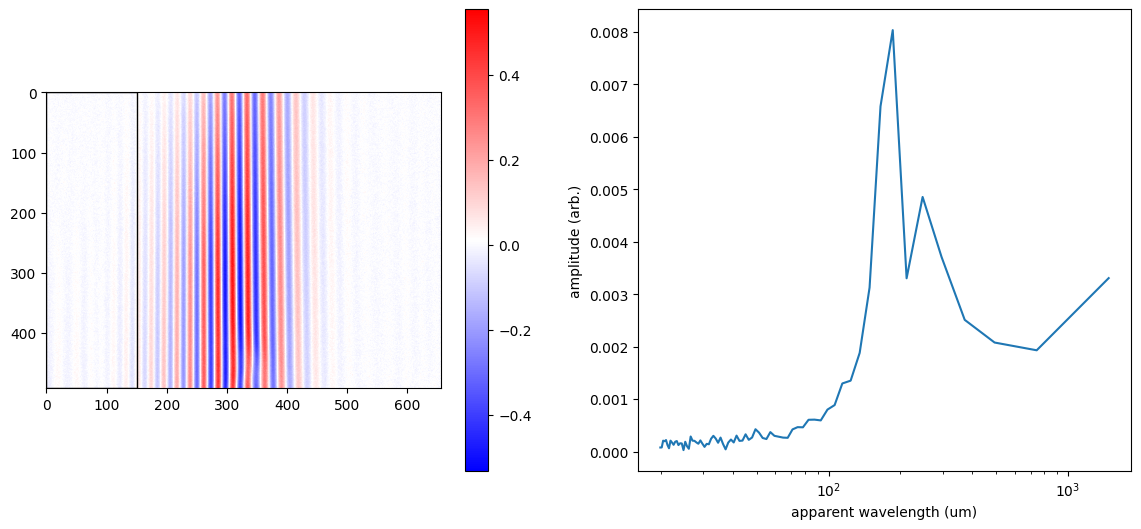

In [44]:
step = 20

##############COMPENSATE FOR BACKGROUND################
nofringes = beamA +beamB -background

if False: #toggle which meathod you want to use. IDK which one is better.
    beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
else:
    beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors
    beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                            posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                            neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                            nan= 0) #occors for 0/0
    beamPost -= 1

##############AVERAGE WITHIN THE ROI####################
ROI = [0,0,150,491] #region of interest in x, y, width, height. [0,0,655,491]
average_signal = np.mean(beamPost[ROI[1]:ROI[3]+ROI[1], ROI[0]:ROI[2]+ROI[0]], axis = 0)

#############FOURIER FOR WAVENUMBERS#############
def FourierAndWavenumbers(signal):
        FT = np.fft.fft(signal, norm = "forward")
        num_of_freqs = len(FT)//2 +1
        samples = len(FT)
        freqs = np.linspace(-1/2/pixel_pitch, 0, num_of_freqs) #niquist frequency = 1/2 * 1/pixel_pitch
        freqs = np.concatenate((freqs, -freqs[-2::-1]))
        freqs = freqs[:len(FT)]
        return FT, freqs

FT, freqs = FourierAndWavenumbers(average_signal)

############CONVERT TO WAVELENGTHS AND AMPLITUDES###############
def Coeffients2Amplitudes(FT):
        samples = len(FT)
        num_of_freqs = len(FT)//2 +1
        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])

        if (samples//2 == samples/2): #if even
                amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = -1/freqs[:-num_of_freqs +2]

        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = -1/freqs[:-num_of_freqs +1]

        amplitude = amplitude[::-1] #the largest wavelength is the smallest frequency so the order needs to be reversed

        return amplitude, wavelengths

amplitude, wavelengths = Coeffients2Amplitudes(FT)

#################DEFINE ANIMATION##################

def animate(i):
        average_signal = np.mean(beamPost[ROI[1]:ROI[3]+ROI[1], ROI[0]:ROI[2]+ROI[0]], axis = 0)
        FT, freqs = FourierAndWavenumbers(average_signal)
        amplitude, wavelengths = Coeffients2Amplitudes(FT)

        rect.set_xy((ROI[0], ROI[1])) #move the ROI rectangle

        line2.set_ydata(amplitude[1:])  # update the data.

        ROI[0] += step
        return line2, rect

#########################PLOTTING GRAPHS##########################
plt.figure(figsize = (14,6))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,6))

im1 = ax1.imshow(beamPost, cmap='bwr')
plt.colorbar(im1)
rect = patches.Rectangle((ROI[0], ROI[1]), ROI[2], ROI[3], linewidth=1, edgecolor='k', facecolor='none') # Create a Rectangle patch
ax1.add_patch(rect)

line2, = ax2.plot(wavelengths[:-1], amplitude[1:]) #excule the infinate wavelength
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_23084\2091882736.py:44: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +2]
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\syf83691\AppData\Local\Temp\ipykernel_23084\2091882736.py:44: RuntimeWarning: divide by zero encountered in divide
  wavelengths = -1/freqs[:-num_of_freqs +2]


<Figure size 1400x600 with 0 Axes>

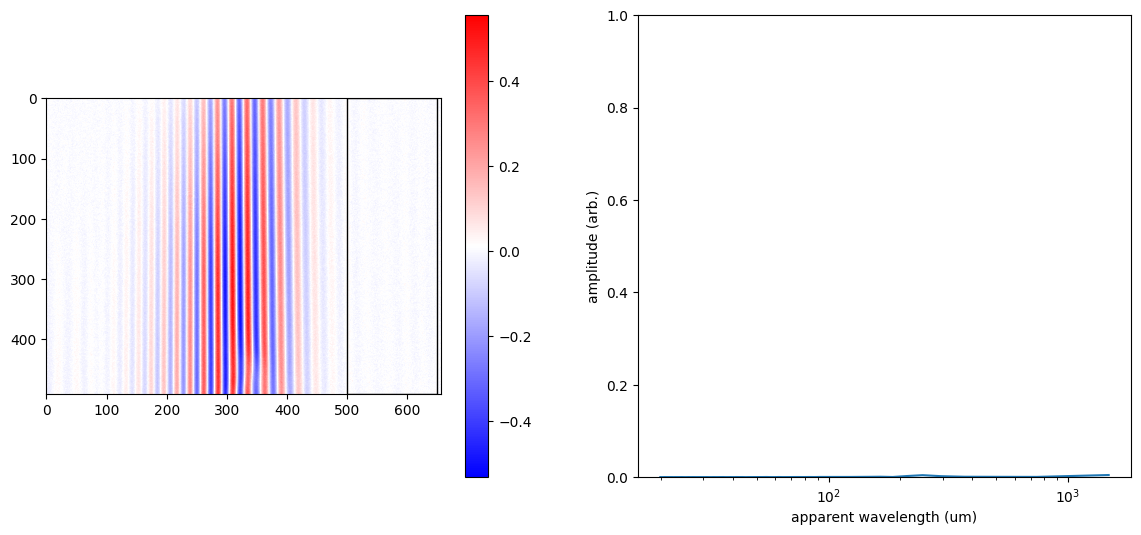

In [47]:
#############ANIMATE GRAPHS###########
plt.figure(figsize = (14,6))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,6))

im1 = ax1.imshow(beamPost, cmap='bwr')
plt.colorbar(im1)
rect = patches.Rectangle((ROI[0], ROI[1]), ROI[2], ROI[3], linewidth=1, edgecolor='k', facecolor='none') # Create a Rectangle patch
ax1.add_patch(rect)

line2, = ax2.plot(wavelengths[:-1], amplitude[1:]) #excule the infinate wavelength
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.ylim(0,1) #would be nice to normalise the amplitudes
#plt.axvline(wavelengths[np.argmax(amplitude)], color = "k")

ani = animation.FuncAnimation(fig,
                              animate,
                              interval=200, #in ms
                              blit=True,
                              save_count=23)

ani.save("movie.gif")

plt.show() #only shows last frame

ROI[0] = 0 #reset the ROI